In [46]:
import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import numpy as np

In [47]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):

    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))

    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    return samples

In [48]:
def potential_grad(sample, mu, cov):

    precision = jnp.linalg.inv(cov)

    return (sample - mu) @ precision

In [49]:
def evolve_langevin(samples, mu, cov, eps=1e-2, n_evolution=5, seed=0):
    
    key = jax.random.PRNGKey(seed)
    evolved_samples = samples

    for i in range(n_evolution):
        key, subkey = jax.random.split(key)
        grad = potential_grad(evolved_samples, mu, cov)
        noise = jax.random.normal(subkey, shape=evolved_samples.shape)
        evolved_samples = evolved_samples - eps * grad + jnp.sqrt(2 * eps) * noise

    return evolved_samples

In [50]:
def pairwise_distances(x, y):
    """
    Compute the full pairwise squared Euclidean distance matrix between x and y
    x: (n, d), y: (m, d)
    returns: (n, m) matrix
    """
    x2 = jnp.sum(x**2, axis=1, keepdims=True)  # (n, 1)
    y2 = jnp.sum(y**2, axis=1, keepdims=True)  # (m, 1)
    cross = x @ y.T                             # (n, m)
    return jnp.sqrt(jnp.maximum(x2 - 2 * cross + y2.T, 1e-10))  # sqrt(dist^2 + eps)
    

def compute_energy_distance(x, y):
    n = x.shape[0]
    m = y.shape[0]

    d_xx = pairwise_distances(x, x)
    d_yy = pairwise_distances(y, y)
    d_xy = pairwise_distances(x, y)

    # Energy distance (unbiased)
    e_xx = jnp.sum(d_xx) / (n * n)
    e_yy = jnp.sum(d_yy) / (m * m)
    e_xy = 2 * jnp.sum(d_xy) / (n * m)

    return e_xy - e_xx - e_yy

In [51]:
def lm_loss(samples, mu, cov):

    evolved_samples = evolve_langevin(samples, mu, cov)

    return compute_energy_distance(samples, evolved_samples)

In [52]:
def lm_optimize_with_tracking(samples, true_mu, true_cov, n_epochs=1000, lr=1e-2, seed=10, eps=1e-2, plot_every=2):
    n, d = samples.shape

    key = jax.random.PRNGKey(seed)
    key_mu, key_A = jax.random.split(key)

    mu = jax.random.normal(key_mu, shape=(d,))
    A = jax.random.normal(key_A, shape=(d, d))

    params = {
        "mu": mu,
        "A": A
    }

    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)

    history = {
        "loss": [],
        "mu_l2": [],
        "cov_l2": [],
        "cov_fro": [],
    }

    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        # Tracking
        mu_val = params["mu"]
        A_val = params["A"]
        cov_val = A_val.T @ A_val

        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_val))
        history["cov_l2"].append(jnp.linalg.norm(true_cov - cov_val, ord=2))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_val, ord='fro'))

        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")

    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]

    return final_mu, final_cov, history


In [53]:
mu = jnp.array([0.0, 1.0, -1.0])

cov = jnp.array([
    [1.0, 0.5, 0.2],
    [0.5, 1.0, 0.3],
    [0.2, 0.3, 1.0]
])

In [54]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)

final_mu, final_cov, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=800, lr=0.05, seed = 0)

epoch 0 | loss = 0.007464
epoch 2 | loss = 0.003313
epoch 4 | loss = 0.002115
epoch 6 | loss = 0.001671
epoch 8 | loss = 0.001468
epoch 10 | loss = 0.001370
epoch 12 | loss = 0.001309
epoch 14 | loss = 0.001277
epoch 16 | loss = 0.001253
epoch 18 | loss = 0.001233
epoch 20 | loss = 0.001217
epoch 22 | loss = 0.001198
epoch 24 | loss = 0.001180
epoch 26 | loss = 0.001157
epoch 28 | loss = 0.001132
epoch 30 | loss = 0.001112
epoch 32 | loss = 0.001085
epoch 34 | loss = 0.001058
epoch 36 | loss = 0.001030
epoch 38 | loss = 0.000999
epoch 40 | loss = 0.000957
epoch 42 | loss = 0.000920
epoch 44 | loss = 0.000880
epoch 46 | loss = 0.000853
epoch 48 | loss = 0.000847
epoch 50 | loss = 0.000853
epoch 52 | loss = 0.000860
epoch 54 | loss = 0.000859
epoch 56 | loss = 0.000851
epoch 58 | loss = 0.000839
epoch 60 | loss = 0.000830
epoch 62 | loss = 0.000828
epoch 64 | loss = 0.000828
epoch 66 | loss = 0.000830
epoch 68 | loss = 0.000828
epoch 70 | loss = 0.000820
epoch 72 | loss = 0.000818
epoch 

In [55]:
jnp.set_printoptions(precision=4, suppress=True)

print(jnp.round(mu, 4), "\n\n", jnp.round(final_mu, 4), jnp.linalg.norm(mu - final_mu), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(final_cov, 4), jnp.linalg.norm(cov - final_cov), "\n\n\n")

[ 0.  1. -1.] 

 [ 0.0779  1.1358 -0.7814] 0.26893258 



[[1.  0.5 0.2]
 [0.5 1.  0.3]
 [0.2 0.3 1. ]] 

 [[1.036  0.5011 0.3017]
 [0.5011 1.0532 0.2333]
 [0.3017 0.2333 1.2867]] 0.34045538 





In [56]:
history_np = {k: np.array(v) for k, v in history.items()}

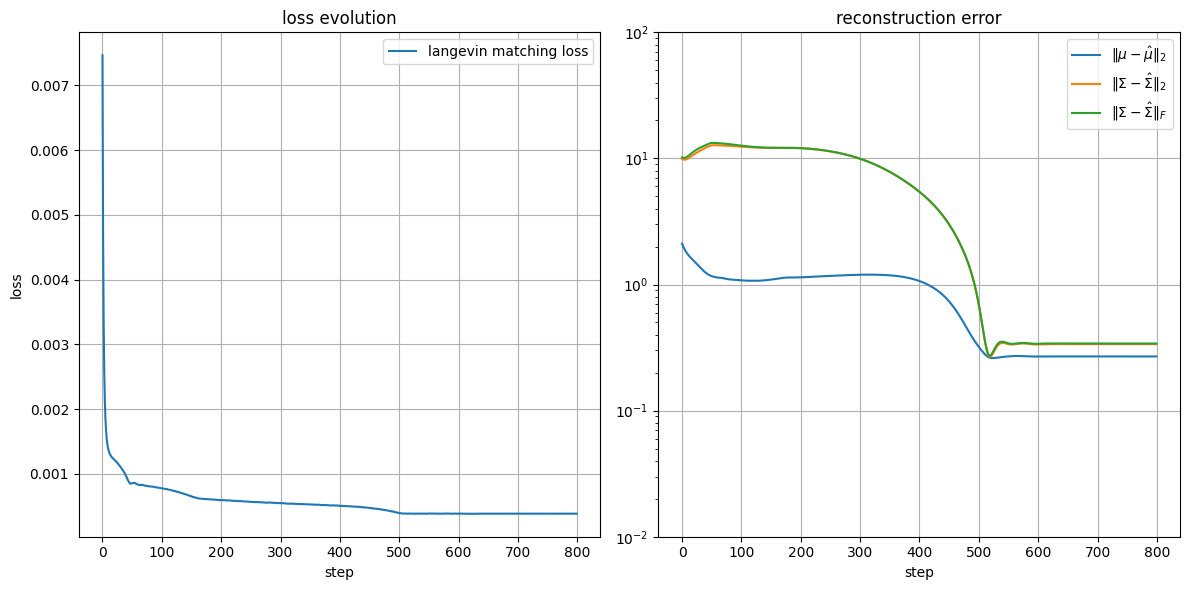

In [60]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="langevin matching loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.title("loss evolution")
plt.grid(True)
plt.legend()

ymin_recon = 1e-2
ymax_recon = 100.0
plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"], label=r"$\| \mu - \hat{\mu} \|_2$")
plt.plot(history_np["cov_l2"], label=r"$\| \Sigma - \hat{\Sigma} \|_2$")
plt.plot(history_np["cov_fro"], label=r"$\| \Sigma - \hat{\Sigma} \|_F$")
plt.ylim(ymin_recon, ymax_recon)
plt.yscale("log")
plt.xlabel("step")
plt.title("reconstruction error")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()